In [ ]:
#importing required librabries

In [105]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [ ]:
#setting image dimensions

In [106]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
#importing train dataset

In [107]:
filenames = os.listdir(r"C:\Users\ritik\Intern\train1")
categories = []
for filename in filenames:
    category = filename.split(' .')[0]
    if category == 'f':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [108]:
df.head()

,filename,category
0,f .1.jpeg,1
1,f .10.jpeg,1
2,f .100.jpeg,1
3,f .101.jpeg,1
4,f .102.jpeg,1


In [109]:
df.tail()

,filename,category
680,h .95.jpeg,0
681,h .96.jpeg,0
682,h .97.jpeg,0
683,h .98.jpeg,0
684,h .99.jpeg,0


In [ ]:
#plotting faulty and healthy dataset - 1-fauthy and 0-healthy


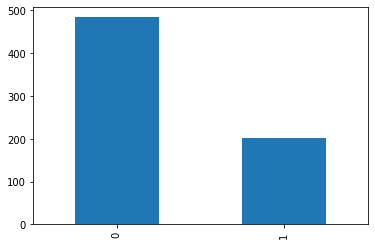

In [110]:
df['category'].value_counts().plot.bar()

In [ ]:
#neural networks and activation functions

In [111]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)       

In [ ]:
#importing earlystopping and ReduceLROnPlateau

In [112]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [113]:
earlystop = EarlyStopping(patience=10)

In [114]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [115]:
callbacks = [earlystop, learning_rate_reduction]

In [116]:
df["category"] = df["category"].replace({0: 'healthy', 1: 'faulty'}) 

In [ ]:
#splitting dataset into train and validate

In [117]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [118]:
train_df.shape

(548, 2)

In [119]:
validate_df.shape

(137, 2)

In [ ]:
#plotting train_dataset

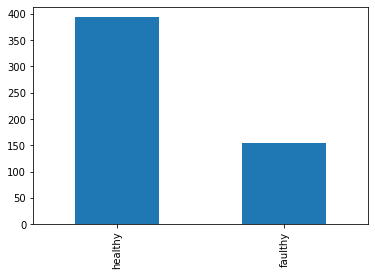

In [121]:
train_df['category'].value_counts().plot.bar()

In [ ]:
#plotting validate_dataset

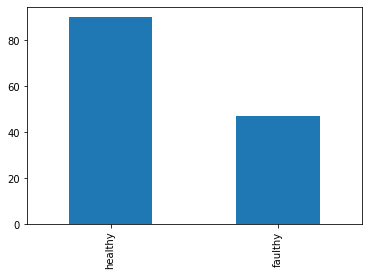

In [122]:
validate_df['category'].value_counts().plot.bar()

In [123]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [ ]:
#using image_data_generator for generating more images

In [124]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    r"C:\Users\ritik\Intern\train1", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 548 validated image filenames belonging to 2 classes.


In [125]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"C:\Users\ritik\Intern\train1", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 137 validated image filenames belonging to 2 classes.


In [126]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    r"C:\Users\ritik\Intern\train1", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [ ]:
#plotting a particular image using image data generator

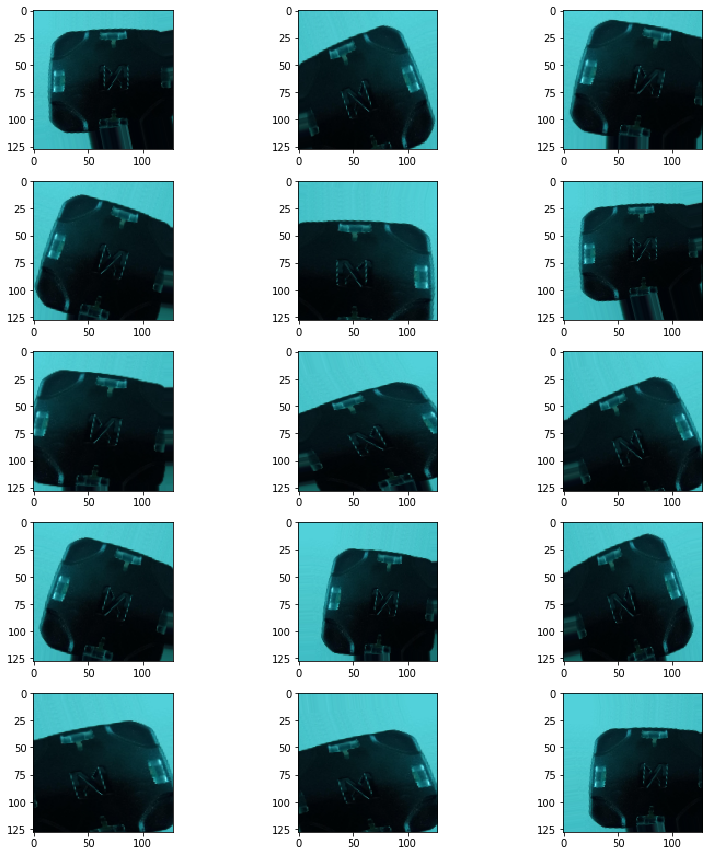

In [127]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
#performing epoch

In [128]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
36/36 [==============================] - 67s 2s/step - loss: 0.5083 - accuracy: 0.9212 - val_loss: 5.6294 - val_accuracy: 0.6593
Epoch 2/50
36/36 [==============================] - 56s 2s/step - loss: 0.0680 - accuracy: 0.9644 - val_loss: 8.8974 - val_accuracy: 0.6667
Epoch 3/50
36/36 [==============================] - 57s 2s/step - loss: 0.1626 - accuracy: 0.9850 - val_loss: 10.6157 - val_accuracy: 0.6593
Epoch 4/50
36/36 [==============================] - 58s 2s/step - loss: 0.1284 - accuracy: 0.9756 - val_loss: 9.4449 - val_accuracy: 0.6593
Epoch 5/50
36/36 [==============================] - 57s 2s/step - loss: 0.0776 - accuracy: 0.9850 - val_loss: 1.7093 - val_accuracy: 0.7407
Epoch 6/50
36/36 [==============================] - 57s 2s/step - loss: 0.0772 - accuracy: 0.9831 - val_loss: 0.8511 - val_accuracy: 0.8296
Epoch 7/50
36/36 [==============================] - 56s 2s/step - loss: 0.0408 - accuracy: 0.9850 - val_loss: 0.0188 - val_accuracy: 0.9926
Epoch 8/50
36/36 [=

36/36 [==============================] - 57s 2s/step - loss: 0.0234 - accuracy: 0.9944 - val_loss: 3.7189e-06 - val_accuracy: 1.0000
Epoch 23/50
36/36 [==============================] - 57s 2s/step - loss: 0.0292 - accuracy: 0.9944 - val_loss: 1.2108e-05 - val_accuracy: 1.0000
Epoch 24/50
36/36 [==============================] - 57s 2s/step - loss: 0.0660 - accuracy: 0.9887 - val_loss: 8.4145e-04 - val_accuracy: 1.0000
Epoch 25/50
36/36 [==============================] - 57s 2s/step - loss: 0.0084 - accuracy: 0.9962 - val_loss: 1.5468e-04 - val_accuracy: 1.0000
Epoch 26/50
36/36 [==============================] - 58s 2s/step - loss: 0.1617 - accuracy: 0.9925 - val_loss: 2.0846e-04 - val_accuracy: 1.0000
Epoch 27/50
36/36 [==============================] - 57s 2s/step - loss: 0.0509 - accuracy: 0.9887 - val_loss: 1.0510e-04 - val_accuracy: 1.0000
Epoch 28/50
36/36 [==============================] - 57s 2s/step - loss: 0.0236 - accuracy: 0.9944 - val_loss: 0.0323 - val_accuracy: 0.9852
E

In [ ]:
#plotting graphs

In [129]:
model.save_weights("model.h5")

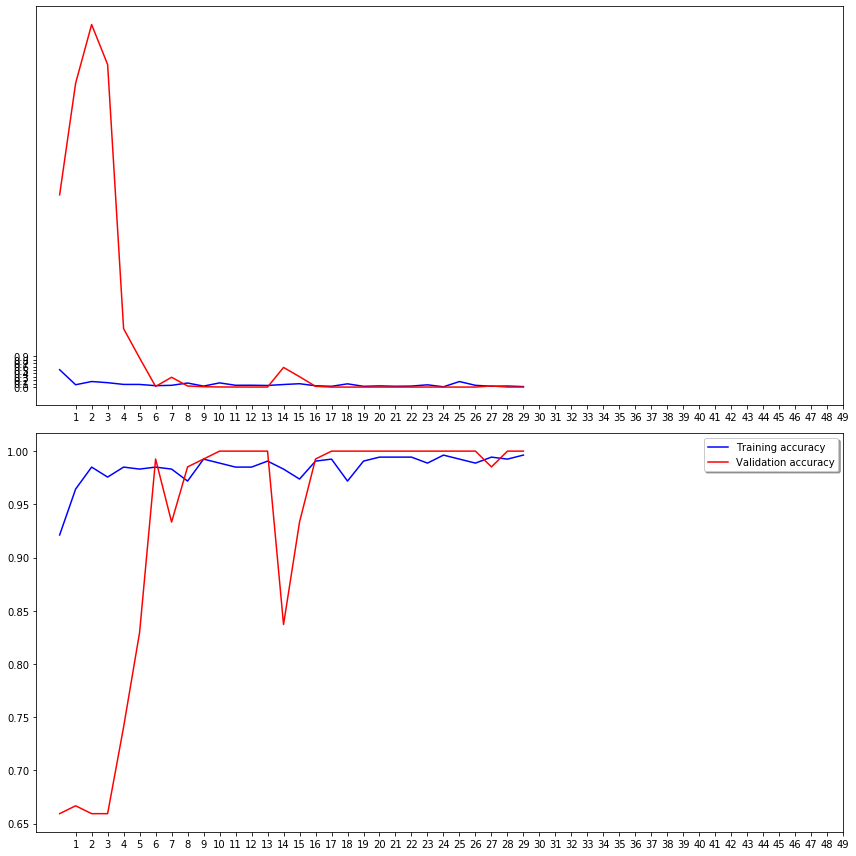

In [130]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
#importing test dataset

In [131]:
test_filenames = os.listdir(r"C:\Users\ritik\Intern\test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [132]:
test_df.shape

(135, 1)

In [ ]:
#using image_data_generator

In [133]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"Intern/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 135 validated image filenames.


In [134]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [135]:
test_df['category'] = np.argmax(predict, axis=-1)

In [136]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [137]:

test_df['category'] = test_df['category'].replace({ 'f': 1, 'h': 0 })

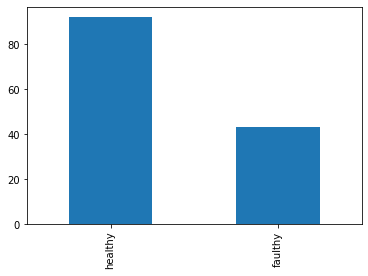

In [138]:
test_df['category'].value_counts().plot.bar()

In [ ]:
#plotting results

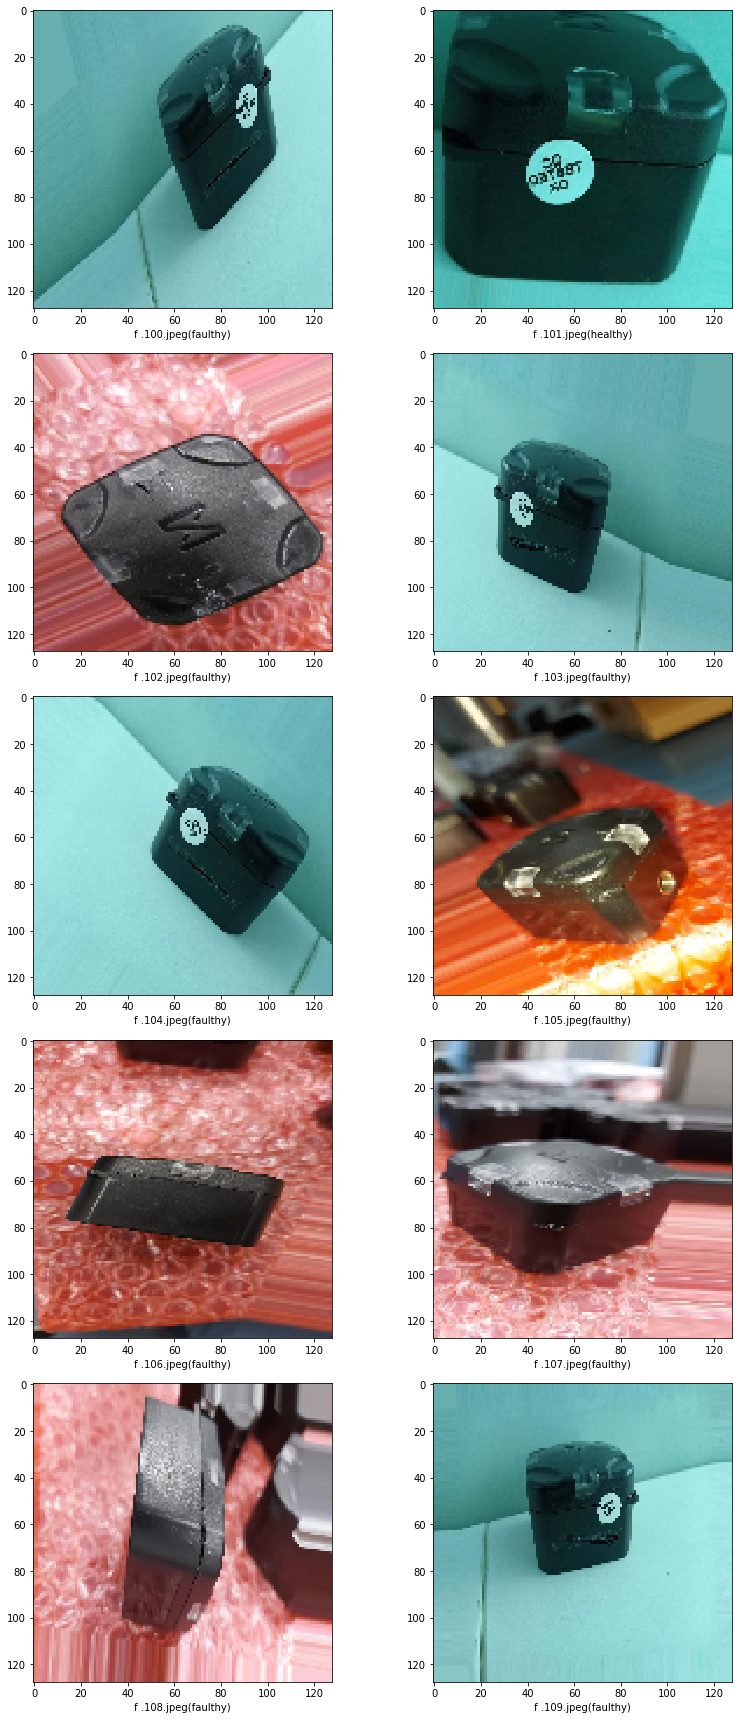

In [139]:
sample_test = test_df.head(10)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(r"Intern/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(5,2, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
#classification report

In [141]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
actual = ['f','h', 'f', 'h', 'h', 'h', 'f', 'h', 'f', 'f']
predicted = ['f', 'h', 'f', 'f', 'h', 'h', 'f', 'h', 'f', 'f']
results = confusion_matrix(actual, predicted)
print ('Confusion Matrix :')
print(results)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print('Classification Report : ')
print (classification_report(actual, predicted))

Confusion Matrix :
[[5 0]
 [1 4]]
Accuracy Score : 0.9
Classification Report : 
              precision    recall  f1-score   support

           f       0.83      1.00      0.91         5
           h       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



In [ ]:
#accuracy Score

In [142]:
from sklearn.metrics import accuracy_score
x=accuracy_score(actual,predicted)
print("Accuracy score: ",x)

Accuracy score:  0.9


In [ ]:
#mcc(matthews correlation coefficient) Score

In [144]:
from sklearn.metrics import matthews_corrcoef
print("MCC : ",matthews_corrcoef(actual,predicted))

MCC :  0.816496580927726


In [ ]:
#

In [145]:
import numpy as np
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(actual,predicted)

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print("TPR : ",TPR)
print("FPR : ",FPR)

TPR :  [1.  0.8]
FPR :  [0.2 0. ]


In [ ]:
j